<a href="https://colab.research.google.com/github/ortegatiago/covid19_analysis/blob/master/covid19_prediction_phophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**COVID 19 Predictions using python Facebook Prophet**

Author: Ortega, Tiago

email: ortega.tiago@gmail.com

github: https://github.com/ortegatiago

linkedin: https://www.linkedin.com/in/ortegatiago/

Facebook Prophet Documentations

https://facebook.github.io/prophet/docs/quick_start.html#python-api


https://facebook.github.io/prophet/


In [2]:
import pandas as pd
from fbprophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

In [3]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/consolidated_covid_19_data.csv', sep=',', encoding='utf-8')
df['Last_Update'] = pd.to_datetime(df['Last_Update'])
df['Last_Update'] = df['Last_Update'].dt.date
df['Last_Update'] = pd.to_datetime(df['Last_Update'])

df = df[['Country_Region','Last_Update', 'Confirmed', 'Deaths', 'Recovered']]
df.tail()

,Country_Region,Last_Update,Confirmed,Deaths,Recovered
425508,West Bank and Gaza,2020-04-29,343,2,71
425509,Western Sahara,2020-04-29,6,0,5
425510,Yemen,2020-04-29,1,0,1
425511,Zambia,2020-04-29,95,3,42
425512,Zimbabwe,2020-04-29,32,4,5


In [4]:
df_p = df.loc[df['Country_Region']=='Brazil',  ['Last_Update', 'Confirmed']].copy()
df_p = df_p.groupby('Last_Update').sum().reset_index()
df_p.rename({'Last_Update':'ds', 'Confirmed':'y'}, inplace=True, axis=1)
#df_p['y'] = np.log(df_p['y'])
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      124 non-null    datetime64[ns]
 1   y       124 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.1 KB


In [5]:
df_p.head()

,ds,y
0,2020-03-22,1546
1,2020-03-23,1924
2,2020-03-24,2247
3,2020-03-25,2554
4,2020-03-26,2985


In [7]:
model = Prophet(growth='linear', interval_width=0.95)
model.fit(df_p)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
df_p.shape

(124, 2)

In [9]:
future = model.make_future_dataframe(periods=30)
future.shape

(154, 1)

In [10]:
forecast = model.predict(future)

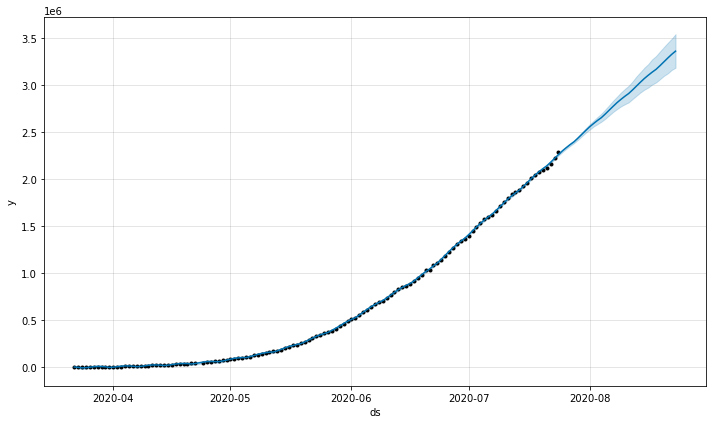

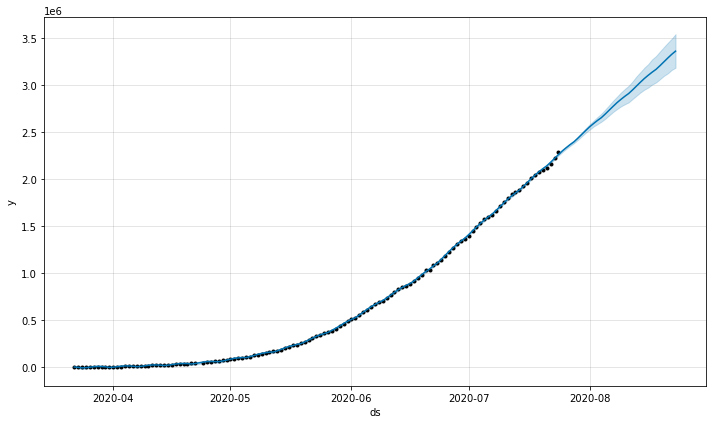

In [11]:
model.plot(forecast)

In [12]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='90 days', period='7 days', horizon = '30 days')
df_cv.tail()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-06-24 00:00:00 and 2020-06-24 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
25,2020-07-20,1.837132e+06,1.711128e+06,1.956406e+06,2098389,2020-06-24
26,2020-07-21,1.861051e+06,1.728260e+06,1.991598e+06,2118646,2020-06-24
27,2020-07-22,1.890351e+06,1.758147e+06,2.023189e+06,2159654,2020-06-24
28,2020-07-23,1.917501e+06,1.770987e+06,2.054678e+06,2227514,2020-06-24
29,2020-07-24,1.946076e+06,1.798614e+06,2.095127e+06,2287475,2020-06-24


In [13]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
23,26 days,6.861940e+10,261953.058770,261949.455820,0.126363,0.127174,0.0
24,27 days,6.807882e+10,260919.183098,260906.496162,0.124421,0.124504,0.0
25,28 days,6.904486e+10,262763.883392,262718.368259,0.123595,0.124504,0.0
26,29 days,7.832910e+10,279873.369445,278970.311128,0.128485,0.124698,0.0
27,30 days,9.506180e+10,308320.940182,306905.011013,0.137706,0.139174,0.0


**Considerations for cross validations**

The blue line is the metric

The dots are the absolut percent of error

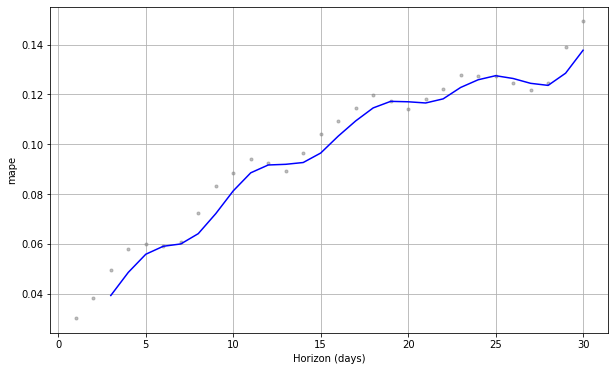

In [14]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [15]:
def plot_covid19_data(countries, case='Confirmed', periods=7, norm=False, peak=False, accumulated=True):
  w = len(countries)
  i = 1

  for country in countries:
    df_p = df.loc[df['Country_Region']==country,  ['Last_Update', case]].copy()
    df_p = df_p.groupby('Last_Update').sum().reset_index()
    df_p[case+"_Shift"] = df_p[case].shift(1)
    df_p[case+"_Daily"] = df_p[case]-df_p[case+"_Shift"]
    df_p[case+"_Daily"].fillna(0, inplace=True)   

    if accumulated:
      df_p.rename({'Last_Update':'ds', case:'y'}, inplace=True, axis=1)
    else:  
      df_p.rename({'Last_Update':'ds', case+"_Daily":'y'}, inplace=True, axis=1)

    if norm:
      #df_p['y'] = np.diff(df_p['y'])
      #df_p['y'] = df_p['y'].diff(1)
      df_p['y'] = df_p['y']/np.linalg.norm(df_p['y'])

      #d.index = np.log(d.index)

    model = Prophet(growth='linear', interval_width=0.95)
    model.fit(df_p)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    fig1 = model.plot(forecast)

    plt.xlabel("Date")
    plt.ylabel("Cases "+case)
    plt.xticks(rotation = 90)
    plt.title("COVID 19 Predictions - "+country)

    if peak:
      min = forecast.loc[forecast['ds']==forecast['ds'].min(), ['ds','yhat']]
      max = forecast.loc[forecast['ds']==forecast['ds'].max(), ['ds','yhat']]
      max['yhat'] = df_p.loc[df_p['ds'] == df_p['ds'].max(), 'y'].max()
      min['yhat'] = df_p.loc[df_p['ds'] == df_p['ds'].max(), 'y'].max()
      max.set_index('ds', inplace=True)
      min.set_index('ds', inplace=True)
      n = pd.concat([min,max], axis=0)
      n.plot(ax=fig1.axes[0], color='r', legend=False, kind='line',grid=True)
    i=i+1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


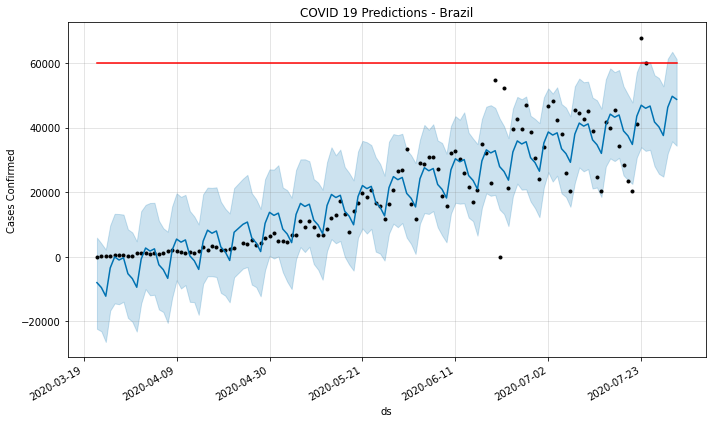

In [19]:
plot_covid19_data(['Brazil'], case='Confirmed', periods=7, norm=False, peak=True, accumulated=False)